# Stacking
## test 용 def

In [71]:
cd /content/drive/My Drive/쇼핑광고등어/3. Modeling

/content/drive/My Drive/쇼핑광고등어/3. Modeling


In [72]:
# ready
import os
import sys
import imp
import joblib
import glob
import time 
import pickle
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np


from IPython.display import display
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# visualize
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

In [4]:
# sklearn
from sklearn.model_selection import KFold, train_test_split


# model
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression

In [5]:
# mape
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# mape with exp
def MAPE_exp(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((np.expm1(y_true) - np.expm1(y_pred)) / np.expm1(y_true))) * 100

#### Load data & Pred & Models

In [73]:
# load train data
train = joblib.load(os.path.join('..', '1. Data', '05_분석데이터', 'train_FE.pkl'))
locals().update(train)

# X, y 설정
train_X = train['X'] ; train_y = train['y'] 
train_log_y = np.log1p(train_y)

In [74]:
# load test data
test = joblib.load(os.path.join('..', '1. Data', '05_분석데이터', 'test_FE.pkl'))
locals().update(test)

# X, y 설정
test_X = test['X'] ; test_idx = test['idx']

In [75]:
train_X.shape, train_y.shape, test_X.shape 

((35379, 401), (35379,), (2716, 401))

## Make Dataset

In [76]:
def Stacking_df(X=train_X, y=train_y, seed=117):
    # 여기부터
    # --------------------------------------------------------------------------------------------
    # pickle 불러오기
    # --------------------------------------------------------------------------------------------

    # Pred : 경로 설정 주의 
    pkls = glob.glob(os.path.join("stacking pred", f'*_{seed}.pickle'))
    
    final = dict()
    for p in pkls : 
        with open('{}'.format(p), 'rb') as f:
            final[os.path.splitext(p)[0].split("/")[1]] = pickle.load(f)

    print('='*80)
    print('* Seed : ', seed, '\t * Used Model len : ', len(final))     # len(final) 확인


    # --------------------------------------------------------------------------------------------
    # index 설정
    # --------------------------------------------------------------------------------------------
    # test
    X_test = X.loc[final[f'pred_catBO_{seed}']['test_idx'][0]]
    y_test = y.loc[final[f'pred_catBO_{seed}']['test_idx'][0]]
    # train
    X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=seed)
    X_train, y_train = dict(), dict() 

    cv = KFold(n_splits=5, random_state=77, shuffle=True)

    i = 0
    for t,v in cv.split(X_train_):
        X_train['{}'.format(i+1)] = X_train_.iloc[v]
        y_train['{}'.format(i+1)] = y_train_.iloc[v]
        i+=1

    # --------------------------------------------------------------------------------------------
    # Final Stacking dataset 설정
    # --------------------------------------------------------------------------------------------
    # cv=5 갯수만큼

    # train : y_true
    y_train1, y_train2, y_train3, y_train4, y_train5 = y_train['1'], y_train['2'], y_train['3'], y_train['4'], y_train['5']

    # shape 확인
    print('='*80)
    print(y_train1.shape, y_train2.shape, y_train3.shape, y_train4.shape, y_train5.shape)
    print('-'*80)

    # train : y_pred
    x_train1, x_train2, x_train3, x_train4, x_train5 = [], [], [], [], []
    for model in list(final.keys()) : 
        x_train1.append(final[model]['val_pred'][0])
        x_train2.append(final[model]['val_pred'][1])
        x_train3.append(final[model]['val_pred'][2])
        x_train4.append(final[model]['val_pred'][3])
        x_train5.append(final[model]['val_pred'][4])

    # transpose
    X_train1 = pd.DataFrame(np.array(x_train1).T)
    X_train2 = pd.DataFrame(np.array(x_train2).T)
    X_train3 = pd.DataFrame(np.array(x_train3).T)
    X_train4 = pd.DataFrame(np.array(x_train4).T)
    X_train5 = pd.DataFrame(np.array(x_train5).T)

    # shape : (5661, n) - n : 각 seed의 모델 갯수 
    print(X_train1.shape, X_train2.shape, X_train3.shape, X_train4.shape, X_train5.shape)
    print('-'*80)

    # test : y_true 
    y_test = y_test


    # test : y_pred 
    x_test = [] 
    for model in list(final.keys()) : 
        x_test.append(final[model]['final_pred'][0])

    X_test = pd.DataFrame(np.array(x_test).T)
    X_test.columns = list(final.keys())

    # --------------------------------------------------------------------------------------------
    # Stacking dataset 설정
    # --------------------------------------------------------------------------------------------

    # train for stacking 
    st_x_train = pd.concat([X_train1, X_train2, X_train3, X_train4, X_train5], axis=0) # 예측값 
    st_y_train = pd.concat([y_train1, y_train2, y_train3, y_train4, y_train5], axis=0) # 실제값

    # test for stacking 
    st_x_test = X_test # 예측값 
    st_y_test = y_test # 실제값

    st_x_train.columns, st_x_test.columns  = list(final.keys()), list(final.keys())

    # shape 확인
    print(st_x_train.shape, st_y_train.shape)
    print(st_x_test.shape, st_y_test.shape)
    print('-'*80)

    return st_x_train, st_x_test, st_y_train, st_y_test

## Stacking

In [77]:
def stacking_coef(X=train_X, y=train_y, seed=117) : 
    # --------------------------------------------------------------------------------------------
    # Meta Train, Meta Test 값으로 최종 Stacking Model인 Linear Regression 수행 
    # -------------------------------------------------------------------------------------------- 
    
    x_train, x_test, y_train, y_test = Stacking_df(X, y, seed)

    lr = LinearRegression() 

    # seed 117 
    lr.fit(x_train, y_train)
    coef = lr.coef_ 
    intercept = lr.intercept_ 

    # coef 확인 
    print('coef : ', lr.coef_)
    print('intercept : ', lr.intercept_)
    print('='*80)

    return coef, intercept 

In [78]:
def seed_y_pred(train_X, train_y, test_X, seed=117) : 
    # --------------------------------------------------------------------------------------------
    # Stacking Model에서 찾아낸 coef, intercept 값을 이용해 prediction y값 예측 
    # -------------------------------------------------------------------------------------------- 

    coef, intercept = stacking_coef(train_X, train_y, seed)

    # Models
    pkls = glob.glob(os.path.join("models", f'*_{seed}.pickle'))

    models = dict()


    # 학습시킨 Models 불러오기 : 경로 설정 주의 
    for p in pkls : 
        with open('{}'.format(p), 'rb') as f:
            models[os.path.splitext(p)[0].split("/")[1]] = pickle.load(f)


    # len(models) 확인
    print('* Seed : ', seed, '\t * Train Model len : ', len(models)) 
    print('='*80)


    # --------------------------------------------------------------------------------------------
    # 학습시킨 모델로 test_X 에 대한 값 예측 
    # -------------------------------------------------------------------------------------------- 

    start_time = time.time()

    test_pred = dict() 
    for model, regressor in models.items() : 
        y_pred = np.zeros(len(test_X))
        for reg in regressor : 
            y_pred += np.expm1(reg.predict(test_X)) / 5 

        test_pred[model] = y_pred


    print('Finish Prediction!')
    print("Working Time: {} seconds".format(time.time() - start_time))
    print('='*80)


    # --------------------------------------------------------------------------------------------
    # 각 모델에 대한 값을 예측해 dataframe을 만들고, 
    # 해당 모델에 적합한 coef 값을 곱하고, intercept 값을 더하여 final_y 값 예측  
    # -------------------------------------------------------------------------------------------- 

    pred_df = pd.DataFrame(test_pred)
    pred_df["y_pred"] = pred_df.multiply(coef.T).sum(axis=1) + intercept
    

    return pred_df["y_pred"]

In [79]:
seedlist = [117, 318, 821, 1009]

In [83]:
def final_y_pred(train_X, train_y, test_X, seedlist) :
    final_pred = np.zeros(len(test_X))

    # --------------------------------------------------------------------------------------------
    # 하나의 seed에 대해 overfitting 되는 것을 방지하기 위해, 여러 seed에서 값을 예측하고, 예측된 값들의 평균을 사용 
    # -------------------------------------------------------------------------------------------- 
    
    for seed in seedlist : 
        final_pred += seed_y_pred(train_X, train_y, test_X, seed) / len(seedlist) 

    return final_pred

In [88]:
def submission(train_X, train_y, test_X, test_idx, seedlist, mkfile=True) : 
    # --------------------------------------------------------------------------------------------
    # 최종 예측 값 dataframe 생성 
    # -------------------------------------------------------------------------------------------- 

    # final predict
    y = final_y_pred(train_X, train_y, test_X, seedlist)
    y.index = test_idx

    # 취급액의 특성을 반영하기 위해, 백의자리 기준으로 반올림 
    sub = np.round(y, -2)


    data = pd.read_excel(os.path.join("..", "1. Data", "02_평가데이터", "2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx"), skiprows=1)
    data["취급액"] = sub 
        

    if mkfile : 
        data.to_excel("쇼핑광고등어_2020년 6월 판매실적예측데이터(평가데이터).xlsx")


    return data

In [89]:
%%time
submission(train_X, train_y, test_X, test_idx, seedlist)

* Seed :  117 	 * Used Model len :  4
(5661,) (5661,) (5661,) (5660,) (5660,)
--------------------------------------------------------------------------------
(5661, 4) (5661, 4) (5661, 4) (5660, 4) (5660, 4)
--------------------------------------------------------------------------------
(28303, 4) (28303,)
(7076, 4) (7076,)
--------------------------------------------------------------------------------
coef :  [ 0.13980088  0.30351733  0.59535046 -0.00181155]
intercept :  531120.9285831414
* Seed :  117 	 * Train Model len :  4
Finish Prediction!
Working Time: 36.145777225494385 seconds
* Seed :  318 	 * Used Model len :  4
(5661,) (5661,) (5661,) (5660,) (5660,)
--------------------------------------------------------------------------------
(5661, 4) (5661, 4) (5661, 4) (5660, 4) (5660, 4)
--------------------------------------------------------------------------------
(28303, 4) (28303,)
(7076, 4) (7076,)
---------------------------------------------------------------------------

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,2020-06-01 06:20:00,20.000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,14727600.000
1,2020-06-01 06:40:00,20.000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,21794400.000
2,2020-06-01 07:00:00,20.000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,25518200.000
3,2020-06-01 07:20:00,20.000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,17207800.000
4,2020-06-01 07:40:00,20.000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,26210900.000
...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,nan
2887,2020-07-01 00:40:00,20.000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,nan
2888,2020-07-01 01:00:00,20.000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,0,nan
2889,2020-07-01 01:20:00,20.000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,10930000.000


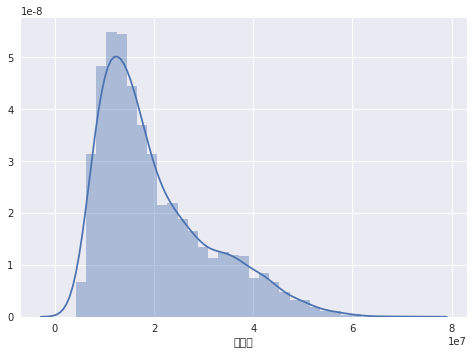

In [93]:
sns.distplot(data["취급액"])

In [94]:
data[["취급액"]].describe()

,취급액
count,2716.000
mean,20107858.800
std,11141850.206
min,4216000.000
25%,11595225.000
50%,16679950.000
75%,26125500.000
max,71959000.000
